# Тестовое задание в RecSys VK

---

## Задача
**Датасет:** [датасет](https://www.kaggle.com/competitions/kkbox-music-recommendation-challenge/data) прослушиваний музыки.

**Задача:** на основе этих данных построить рекомендательную систему релевантных треков для пользователей и оценить ее качество.

**Метрика:** NDCG@20.

**Что будет оцениваться:**

1. Наличие и содержательность exploratory data analysis
2. Пайплайн обучения модели: подготовка данных, feature engineering, выбор модели, выбор loss функции, корректная оценка метрик качества
3. Наличие и содержательность комментариев к происходящему
4. Финальный скор

---

## Summary

**Разделы ноутбука:**
- Fetching dataset - скачивание данных, распаковка и пр.
- EDA - анализ и обработка данных
- CatBoostClassifier - обучение классификатора на target, evaluation классификатора
- Recommendations - реализация рекомендаций, оценка ранжирования, подсчет метрики NDCG@20

**Results:**
1. Проанализированы и предобработаны данные

2. Обучена модель бинарной классификации - градиентный бустинг

3. Реализован алгоритм ранжирования на основе псевдовероятностей из бустинга

4. Подсчитаны метрики NDCG@20 в 3 случаях:
    1. NDCG@20=0.8356 при positive_count=10
    2. NDCG@20=0.6754 при positive_count=5
    3. NDCG@20=0.5944 при positive_count=3
    
5. Во всех случаях алгоритм показал себя лучше, чем базовый (рандомное ранжирование)

## Imports

In [1]:
# импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

## Fetching dataset

In [2]:
# подключаю гугл диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# импортирую кэггл файл, чтобы работать с апи
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/colab_files/kaggle.json ~/.kaggle/
! pip install -qq kaggle
! kaggle --version

Kaggle API 1.5.16


In [4]:
# загружаю датасет с кэггла
# и распаковываю архив (и файлы из него - тоже архивы)
! kaggle competitions download -c kkbox-music-recommendation-challenge

 95% 328M/345M [00:02<00:00, 172MB/s]
100% 345M/345M [00:02<00:00, 157MB/s]


In [5]:
! unzip kkbox-music-recommendation-challenge.zip

Archive:  kkbox-music-recommendation-challenge.zip
  inflating: members.csv.7z          
  inflating: sample_submission.csv.7z  
  inflating: song_extra_info.csv.7z  
  inflating: songs.csv.7z            
  inflating: test.csv.7z             
  inflating: train.csv.7z            


In [6]:
! apt-get install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [7]:
import os

In [8]:
for arxiv in [f for f in os.listdir() if f.endswith('.7z')]:
    ! p7zip -d $arxiv


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 103608205 bytes (99 MiB)

Extracting archive: song_extra_info.csv.7z
--
Path = song_extra_info.csv.7z
Type = 7z
Physical Size = 103608205
Headers Size = 140
Method = LZMA:25
Solid = -
Blocks = 1

  0%      1%      2% - song_extra_info.csv                            4% - song_extra_info.csv                            6% - song_extra_info.csv                            7% - song_extra_info.csv                            9% - song_extra_info.csv                         

In [9]:
! ls -al

total 2066496
drwxr-xr-x 1 root root      4096 Apr  1 12:49 .
drwxr-xr-x 1 root root      4096 Apr  1 12:47 ..
drwxr-xr-x 4 root root      4096 Mar 28 22:59 .config
drwx------ 5 root root      4096 Apr  1 12:48 drive
-rw-r--r-- 1 root root 361666592 Dec 11  2019 kkbox-music-recommendation-challenge.zip
-rw-r--r-- 1 root root   2503827 Sep 22  2017 members.csv
drwxr-xr-x 1 root root      4096 Mar 28 23:00 sample_data
-rw-r--r-- 1 root root  29570380 Sep 22  2017 sample_submission.csv
-rw-r----- 1 root root 181010294 Sep 29  2017 song_extra_info.csv
-rw-r--r-- 1 root root 221828666 Sep 22  2017 songs.csv
-rw-r--r-- 1 root root 347789925 Sep 22  2017 test.csv
-rw-r--r-- 1 root root 971675848 Sep 22  2017 train.csv


## EDA

### Train

- вместо nan записал unk

In [2]:
# импорт трейн датасета
train_df = pd.read_csv('train.csv')
train_df

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1
...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1


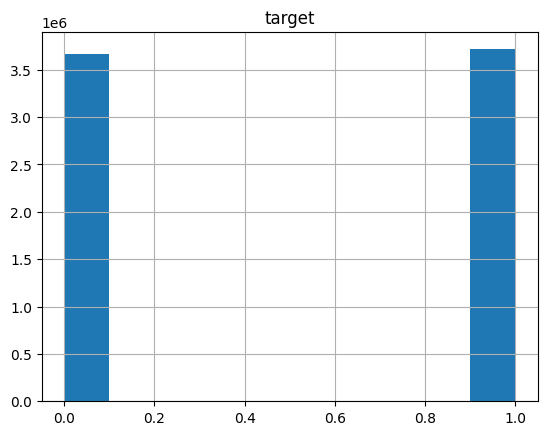

In [3]:
train_df['target'].hist()
plt.title('target')
None

In [4]:
# смотрю какие фичи могут быть nan
train_df[train_df.isna().any(axis=1)]

,msno,song_id,source_system_tab,source_screen_name,source_type,target
12,TJU0Gfvy7FB+r89bWovPKXTjuApTCiv3xg/tt5shR78=,u6/Pb7X4u7KU4gXrBgGqt8RlRrNNFLn03tLAHyxRxwA=,my library,NaN,top-hits-for-artist,0
18,TJU0Gfvy7FB+r89bWovPKXTjuApTCiv3xg/tt5shR78=,4ZISq5iNKgBGGW2OvKBBzBsYXRohcJYFkqx3uVFCAuA=,my library,NaN,top-hits-for-artist,0
75,zcCi+lR4SecPMBbZEwj4UUBrWhgBUbxx+t4O5KA28K8=,3RnXpHSbz61HoSCJEB7B9Sn3bqKPUvgYVwM8ceOEd1M=,discover,NaN,top-hits-for-artist,1
86,rAI+tZ85/S4CEHBEhUkHDLO1afqVLArCu0nsBmORwfQ=,U03If8ekFQ69MIodnGZOgaFV9vbFpwDQZQYCf5To5fo=,NaN,NaN,NaN,0
88,rAI+tZ85/S4CEHBEhUkHDLO1afqVLArCu0nsBmORwfQ=,yv4Nasbw8r06KtMHzaEMF/SrpYPv+V73JrwFClUoRQ0=,NaN,NaN,NaN,0
...,...,...,...,...,...,...
7377367,O3CsBhmCxwqe8acAy5Xdc4FQQoRgkHZrYJ8SxxOkbD8=,W49hU5i7sopbmCqzlNLKvv7mbRIG4pGn8E4W9F14X3s=,my library,NaN,top-hits-for-artist,1
7377368,O3CsBhmCxwqe8acAy5Xdc4FQQoRgkHZrYJ8SxxOkbD8=,vdbUGlcRq3cB0XvkCYSTlMEVYMKEDlGauRA7iElyxXQ=,my library,NaN,top-hits-for-artist,1
7377402,CRo1X/++zVnTpjJ4RzHSKzQCjUjn5FK11LtDWgGKtrY=,9NrqJ36mURDvRECILJfsJuPPNBz/Lq39YANZBuYbTeg=,discover,NaN,song-based-playlist,0
7377403,CRo1X/++zVnTpjJ4RzHSKzQCjUjn5FK11LtDWgGKtrY=,ngHLycwRjBbLxc/1GeJgaPsuifgiYH1ctvWYesXwlbE=,discover,NaN,song-based-playlist,1


In [5]:
cat_features = [
    'source_system_tab',
    'source_screen_name',
    'source_type',
]

In [6]:
# заменяю nan на unk
for cat in cat_features:
    train_df.loc[train_df[cat].isna(), cat] = 'unk'

<ipython-input-7-7303658836bd>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, i)


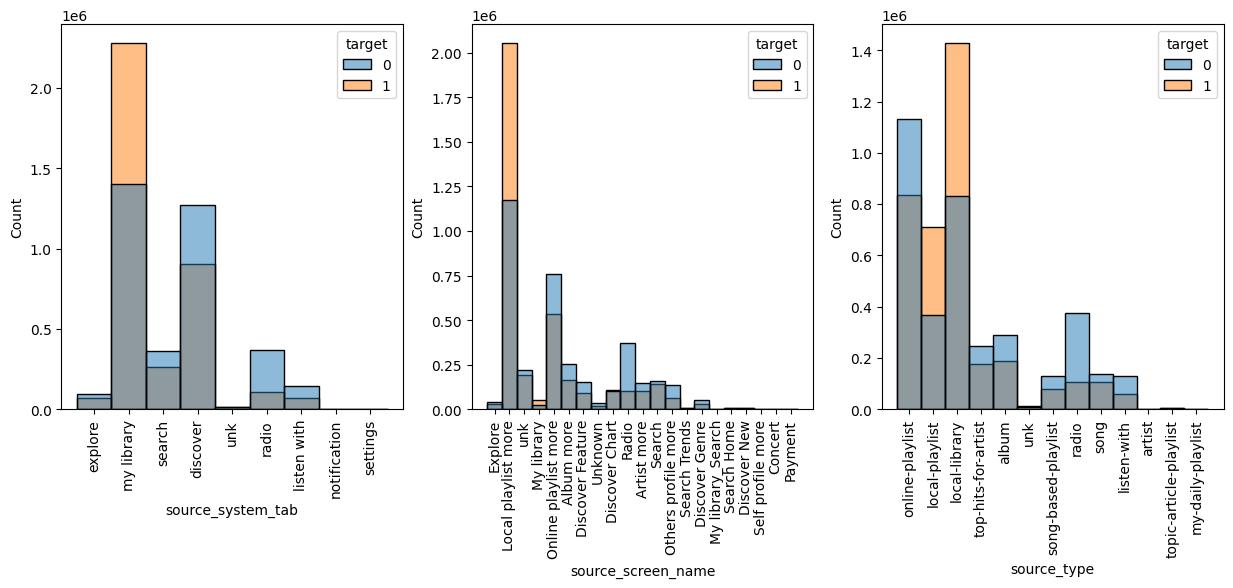

In [7]:
# распределения значений категориальных фичей
plt.figure(figsize=(15, 5))
plt.title('train.csv cat_features histograms')

for i, cat in enumerate(cat_features, start=1):
    plt.subplot(1, 3, i)
    sns.histplot(data=train_df, x=cat, label=cat, hue='target')
    plt.xticks(rotation=90)

### Members

обработаны фичи (nan заменены на unk и прочее)

generated features:

- year, month, day, dayofweek
- sin(month) and cos(month)
- sin(day) and cos(day)

In [8]:
def handle_dates(df, col, prefix):
    """
    функия для обработки фичей с датами
    и генерацией новых признаков по ним

    принимает:
        df - датафрейм
        col - название фичи
        prefix - префикс для генерируемых фичей
    """
    df[f'{prefix}_year'] = df[col].dt.year
    df[f'{prefix}_month'] = df[col].dt.month
    df[f'{prefix}_day'] = df[col].dt.day
    df[f'{prefix}_dayofweek'] = df[col].dt.dayofweek

    df[f'{prefix}_month_sin'] = np.sin(df[col].dt.month / 12 * 2*np.pi)
    df[f'{prefix}_month_cos'] = np.cos(df[col].dt.month / 12 * 2*np.pi)
    df[f'{prefix}_day_sin'] = np.sin(df[col].dt.day / 31 * 2*np.pi)
    df[f'{prefix}_day_cos'] = np.cos(df[col].dt.day / 31 * 2*np.pi)

In [9]:
members_df = pd.read_csv('members.csv')

# category features
members_cat_features = [
    'city',
    # 'bd', # возраст - не категориальная фича
    'gender',
    'registered_via',
]

# date
cols = (
    'registration_init_time',
    'expiration_date',
)
for col, pfx in zip(cols, ('init', 'expir')):
    members_df[col] = pd.to_datetime(members_df[col], format='%Y%m%d')
    handle_dates(members_df, col, pfx)
members_df.drop([*cols], axis=1, inplace=True)

# gender
members_df.loc[members_df['gender'].isna(), 'gender'] = 'unk'

members_df

,msno,city,bd,gender,registered_via,init_year,init_month,init_day,init_dayofweek,init_month_sin,...,init_day_sin,init_day_cos,expir_year,expir_month,expir_day,expir_dayofweek,expir_month_sin,expir_month_cos,expir_day_sin,expir_day_cos
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,unk,7,2011,8,20,5,-8.660254e-01,...,-0.790776,-0.612106,2017,9,20,2,-1.000000e+00,-1.836970e-16,-0.790776,-0.612106
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,unk,7,2015,6,28,6,1.224647e-16,...,-0.571268,0.820763,2017,6,22,3,1.224647e-16,-1.000000e+00,-0.968077,-0.250653
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,unk,4,2016,4,11,0,8.660254e-01,...,0.790776,-0.612106,2017,7,12,2,-5.000000e-01,-8.660254e-01,0.651372,-0.758758
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,unk,9,2015,9,6,6,-1.000000e+00,...,0.937752,0.347305,2015,9,7,0,-1.000000e+00,-1.836970e-16,0.988468,0.151428
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,unk,4,2017,1,26,3,5.000000e-01,...,-0.848644,0.528964,2017,6,13,1,1.224647e-16,-1.000000e+00,0.485302,-0.874347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34398,Wwd/cudKVuLJ3txRVxlg2Zaeliu+LRUfiBmfrnxhRCY=,1,0,unk,7,2013,11,11,0,-5.000000e-01,...,0.790776,-0.612106,2017,9,10,6,-1.000000e+00,-1.836970e-16,0.897805,-0.440394
34399,g3JGnJX6Hg50lFbrNWfsHwCUmApIkiv2M8sXOaeXoIQ=,4,18,male,3,2014,10,24,4,-8.660254e-01,...,-0.988468,0.151428,2017,5,18,3,5.000000e-01,-8.660254e-01,-0.485302,-0.874347
34400,IMaPMJuyN+ip9Vqi+z2XuXbFAP2kbHr+EvvCNkFfj+o=,1,0,unk,7,2013,8,2,4,-8.660254e-01,...,0.394356,0.918958,2017,9,8,4,-1.000000e+00,-1.836970e-16,0.998717,-0.050649
34401,WAnCAJjUty9Stv8yKtV7ZC7PN+ilOy5FX3aIJgGPANM=,1,0,unk,7,2015,10,20,1,-8.660254e-01,...,-0.790776,-0.612106,2017,9,20,2,-1.000000e+00,-1.836970e-16,-0.790776,-0.612106


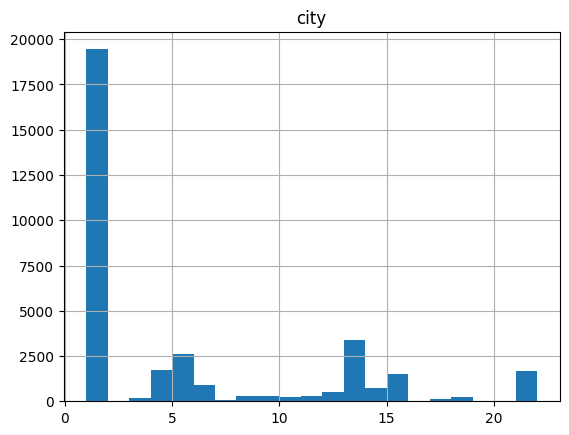

In [10]:
# распределение городов
members_df['city'].hist(bins=21)
plt.title('city')
None

In [11]:
# распределение полов
members_df['gender'].value_counts()

unk       19902
male       7405
female     7096
Name: gender, dtype: int64

In [12]:
# распределение возрастов (очень много нулей - пропущенное значение)
members_df['bd'].value_counts()[:5]

0     19932
22      751
27      750
24      740
26      719
Name: bd, dtype: int64

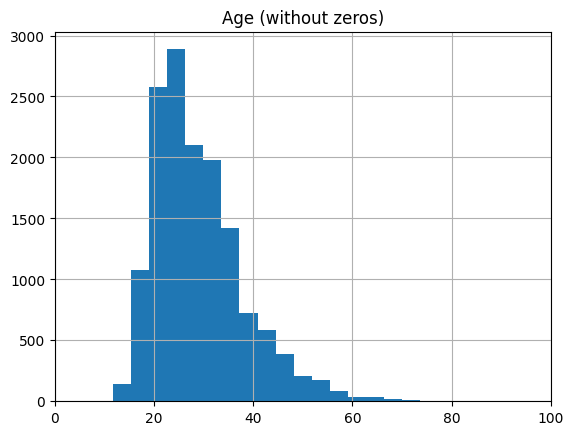

In [13]:
# распределение возрастов
members_df[members_df['bd'] != 0]['bd'].hist(bins=300)
plt.xlim(0, 100)
plt.title('Age (without zeros)')
None

In [14]:
# распределение способов регистрации
members_df['registered_via'].value_counts()

4     11392
7      9433
9      8628
3      4879
13       70
16        1
Name: registered_via, dtype: int64

### Songs

- song_extra_info - не использовал

- обработал фичи - убрал nan

- я отбросил 2ой и следующие жанры при наличии

In [15]:
# импорт таблицы с инфой о песнях
songs_df = pd.read_csv('songs.csv')
songs_df

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
...,...,...,...,...,...,...,...
2296315,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,20192,958,Catherine Collard,Robert Schumann (1810-1856),NaN,-1.0
2296316,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,273391,465,紀文惠 (Justine Chi),NaN,NaN,3.0
2296317,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,445172,1609,Various Artists,NaN,NaN,52.0
2296318,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=,172669,465,Peter Paul & Mary,NaN,NaN,52.0


In [16]:
# количество уникальных значений жанра в исходной
# таблице и проверка на наличие nan
print(len(songs_df['genre_ids'].unique()))
np.nan in songs_df['genre_ids'].unique()

1046


False

In [17]:
# распределение количеств жанров у песни (сколько жанров у песни)
counts = songs_df['genre_ids'].apply(lambda s: str(s).count('|')) + 1
counts.value_counts()

1    2123444
2     138833
3      24064
4       8748
5       1068
6         90
7         62
8         11
Name: genre_ids, dtype: int64

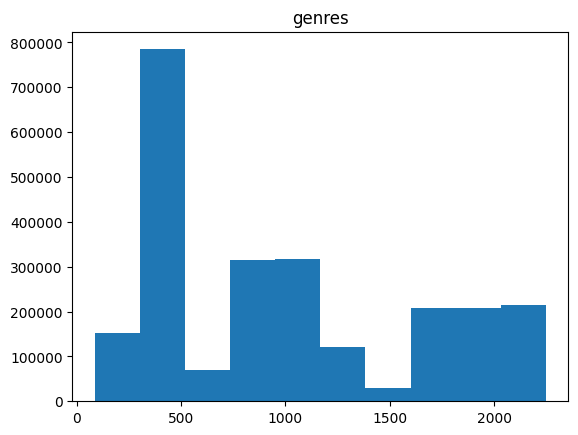

In [18]:
# распределение жанров после обработки
genres = songs_df['genre_ids'].tolist()
genres = [str(g).split('|') for g in genres]

items_genres = []
for g in genres:
    if isinstance(g, list):
        items_genres.extend([int(it) for it in g if it != 'nan'])
    else:
        items_genres.append(int(g))

plt.hist(items_genres)
plt.title('genres')
None

In [19]:
import math


def handle_genre(val):
    """
    функция для обработки жанров (приведение к единому типу)

    также я отбросил 2ой и следующие жанры при наличии
    """
    if isinstance(val, int):
        return val
    elif isinstance(val, float) and (not math.isnan(val)):
        return int(val)
    elif isinstance(val, str):
        return int(val.split('|')[0])
    else:
        return -1

In [20]:
songs_df['genre_ids'] = songs_df['genre_ids'].apply(handle_genre)

In [21]:
# инфа о таблице
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    int64  
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(2), object(4)
memory usage: 122.6+ MB


In [22]:
# распределение языков песен
songs_df.loc[songs_df['language'].isna(), 'language'] = -100 # nan -> -100
songs_df['language'] = songs_df['language'].astype(int)
songs_df['language'].value_counts()

 52     1336694
-1       639467
 3       106295
 17       92518
 24       41744
 31       39201
 10       15482
 45       14435
 59        8098
 38        2385
-100          1
Name: language, dtype: int64

In [23]:
# нет nan (ура!)
songs_df[songs_df['artist_name'].isna()]

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language


In [24]:
# там были nan - заменяю
songs_df.loc[songs_df['composer'].isna(), 'composer'] = ''
songs_df.loc[songs_df['lyricist'].isna(), 'lyricist'] = ''

In [25]:
# таблица после обработки
songs_df

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,,,31
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52
...,...,...,...,...,...,...,...
2296315,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,20192,958,Catherine Collard,Robert Schumann (1810-1856),,-1
2296316,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,273391,465,紀文惠 (Justine Chi),,,3
2296317,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,445172,1609,Various Artists,,,52
2296318,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=,172669,465,Peter Paul & Mary,,,52


### Merging

merge по msno (user id) и song_id

In [26]:
# merging members and train dfs
members_train_df = pd.merge(
    train_df,
    members_df,
    how='left',
    on='msno',
)
members_train_df

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,init_day_sin,init_day_cos,expir_year,expir_month,expir_day,expir_dayofweek,expir_month_sin,expir_month_cos,expir_day_sin,expir_day_cos
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,unk,7,...,0.394356,0.918958,2017,10,5,3,-0.866025,5.000000e-01,0.848644,0.528964
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,-0.937752,0.347305,2017,9,11,0,-1.000000,-1.836970e-16,0.790776,-0.612106
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,-0.937752,0.347305,2017,9,11,0,-1.000000,-1.836970e-16,0.790776,-0.612106
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,-0.937752,0.347305,2017,9,11,0,-1.000000,-1.836970e-16,0.790776,-0.612106
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,unk,7,...,0.394356,0.918958,2017,10,5,3,-0.866025,5.000000e-01,0.848644,0.528964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1,4,26,female,9,...,-0.485302,-0.874347,2017,9,30,5,-1.000000,-1.836970e-16,-0.201299,0.979530
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0,1,0,unk,7,...,-0.724793,0.688967,2017,10,6,4,-0.866025,5.000000e-01,0.937752,0.347305
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1,1,0,unk,7,...,-0.724793,0.688967,2017,10,6,4,-0.866025,5.000000e-01,0.937752,0.347305
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1,5,0,unk,9,...,0.485302,-0.874347,2017,9,18,0,-1.000000,-1.836970e-16,-0.485302,-0.874347


In [27]:
# merging songs and members_train dfs
songs_members_train_df = pd.merge(
    members_train_df,
    songs_df,
    how='left',
    on='song_id',
)
songs_members_train_df

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,expir_month_sin,expir_month_cos,expir_day_sin,expir_day_cos,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,unk,7,...,-0.866025,5.000000e-01,0.848644,0.528964,206471.0,359.0,Bastille,Dan Smith| Mark Crew,,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,-1.000000,-1.836970e-16,0.790776,-0.612106,284584.0,1259.0,Various Artists,,,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,-1.000000,-1.836970e-16,0.790776,-0.612106,225396.0,1259.0,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,-1.000000,-1.836970e-16,0.790776,-0.612106,255512.0,1019.0,Soundway,Kwadwo Donkoh,,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,unk,7,...,-0.866025,5.000000e-01,0.848644,0.528964,187802.0,1011.0,Brett Young,Brett Young| Kelly Archer| Justin Ebach,,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1,4,26,female,9,...,-1.000000,-1.836970e-16,-0.201299,0.979530,267958.0,1259.0,Dr. Dre,Andre R. Young| Melvin Charles Bradford| Shawn...,,52.0
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0,1,0,unk,7,...,-0.866025,5.000000e-01,0.937752,0.347305,227404.0,465.0,R. City feat. Adam Levine,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,52.0
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1,1,0,unk,7,...,-0.866025,5.000000e-01,0.937752,0.347305,258298.0,465.0,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,3.0
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1,5,0,unk,9,...,-1.000000,-1.836970e-16,-0.485302,-0.874347,524146.0,2122.0,Brad Mehldau Trio,,,52.0


In [28]:
# удаляем 114 строк c nan (те строки, которые ни с кем не смержились)
songs_members_train_df.dropna(inplace=True)

In [29]:
cats = [
    'language', 'genre_ids', 'registered_via',
    'init_dayofweek', 'init_month',
    'expir_dayofweek', 'expir_month',
]

for cat in cats:
    print(cat)
    songs_members_train_df[cat] = songs_members_train_df[cat].astype(int)

language
genre_ids
registered_via
init_dayofweek
init_month
expir_dayofweek
expir_month


In [30]:
songs_members_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377304 entries, 0 to 7377417
Data columns (total 32 columns):
 #   Column              Dtype  
---  ------              -----  
 0   msno                object 
 1   song_id             object 
 2   source_system_tab   object 
 3   source_screen_name  object 
 4   source_type         object 
 5   target              int64  
 6   city                int64  
 7   bd                  int64  
 8   gender              object 
 9   registered_via      int64  
 10  init_year           int64  
 11  init_month          int64  
 12  init_day            int64  
 13  init_dayofweek      int64  
 14  init_month_sin      float64
 15  init_month_cos      float64
 16  init_day_sin        float64
 17  init_day_cos        float64
 18  expir_year          int64  
 19  expir_month         int64  
 20  expir_day           int64  
 21  expir_dayofweek     int64  
 22  expir_month_sin     float64
 23  expir_month_cos     float64
 24  expir_day_sin       floa

In [31]:
# saving to file
songs_members_train_df.to_csv('full_train.csv')

In [32]:
! ls -al

total 4837848
drwxr-xr-x 1 root root       4096 Apr  1 12:55 .
drwxr-xr-x 1 root root       4096 Apr  1 12:47 ..
drwxr-xr-x 4 root root       4096 Mar 28 22:59 .config
drwx------ 5 root root       4096 Apr  1 12:48 drive
-rw-r--r-- 1 root root 2837857414 Apr  1 14:03 full_train.csv
-rw-r--r-- 1 root root  361666592 Dec 11  2019 kkbox-music-recommendation-challenge.zip
-rw-r--r-- 1 root root    2503827 Sep 22  2017 members.csv
drwxr-xr-x 1 root root       4096 Mar 28 23:00 sample_data
-rw-r--r-- 1 root root   29570380 Sep 22  2017 sample_submission.csv
-rw-r----- 1 root root  181010294 Sep 29  2017 song_extra_info.csv
-rw-r--r-- 1 root root  221828666 Sep 22  2017 songs.csv
-rw-r--r-- 1 root root  347789925 Sep 22  2017 test.csv
-rw-r--r-- 1 root root  971675848 Sep 22  2017 train.csv


In [33]:
# ! cp full_train.csv /content/drive/MyDrive/colab_files/

## CatBoostClassifier

### Data splitting

Я поставил высокий test_size, чтобы обучающая выборка была порядка ~250k строк. Такое допущение в силу ограниченности времени выполнения тестового задания, и я хочу обучить модель за небольшое время

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
drop_features = [
    'msno',
    'song_id',
]

# split dataset into (TRAIN and TEST)
train_val_df, test_df = train_test_split(
    songs_members_train_df,
    test_size=0.95, # высокий test size
    shuffle=True,
)

# split TRAIN dataset into (TRAIN and VAL)
X_train, X_val, y_train, y_val = train_test_split(
    train_val_df.drop(drop_features + ['target'], axis=1),
    train_val_df['target'],
    test_size=0.3,
    shuffle=True,
)

In [36]:
len(X_train), len(X_val), len(test_df)

(258205, 110660, 7008439)

In [37]:
X_train.columns

Index(['source_system_tab', 'source_screen_name', 'source_type', 'city', 'bd',
       'gender', 'registered_via', 'init_year', 'init_month', 'init_day',
       'init_dayofweek', 'init_month_sin', 'init_month_cos', 'init_day_sin',
       'init_day_cos', 'expir_year', 'expir_month', 'expir_day',
       'expir_dayofweek', 'expir_month_sin', 'expir_month_cos',
       'expir_day_sin', 'expir_day_cos', 'song_length', 'genre_ids',
       'artist_name', 'composer', 'lyricist', 'language'],
      dtype='object')

In [38]:
train_cat_features = cat_features + members_cat_features + [
    'source_system_tab', 'source_screen_name', 'source_type',
    'city', 'gender', 'registered_via',
    'init_month', 'expir_month',
    'init_dayofweek', 'expir_dayofweek',
    'genre_ids', 'language',
]

train_text_features = [
    'artist_name',
    'composer',
    'lyricist',
]

### Training

In [39]:
! pip install -qq catboost

In [40]:
from catboost import CatBoostClassifier

In [41]:
# град. бустинг макс. на 2000 деревьев
model = CatBoostClassifier(
    iterations=2000,
    loss_function='CrossEntropy',
    random_seed=42,
    # task_type="GPU", # for using gpu
    # devices='0',     # for using gpu
)

In [42]:
# тренеруем
model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=30,
    cat_features=train_cat_features,
    text_features=train_text_features,
    # plot=True,
)

0:	learn: 0.6908217	test: 0.6908353	best: 0.6908353 (0)	total: 4.97s	remaining: 2h 45m 42s
1:	learn: 0.6887416	test: 0.6887775	best: 0.6887775 (1)	total: 11.3s	remaining: 3h 8m 5s
2:	learn: 0.6867690	test: 0.6868211	best: 0.6868211 (2)	total: 16.4s	remaining: 3h 1m 35s
3:	learn: 0.6848505	test: 0.6849127	best: 0.6849127 (3)	total: 21.1s	remaining: 2h 55m 7s
4:	learn: 0.6831384	test: 0.6832133	best: 0.6832133 (4)	total: 24.3s	remaining: 2h 41m 22s
5:	learn: 0.6813807	test: 0.6814722	best: 0.6814722 (5)	total: 27.4s	remaining: 2h 31m 53s
6:	learn: 0.6797402	test: 0.6798371	best: 0.6798371 (6)	total: 30.9s	remaining: 2h 26m 49s
7:	learn: 0.6782572	test: 0.6783620	best: 0.6783620 (7)	total: 34.1s	remaining: 2h 21m 39s
8:	learn: 0.6767623	test: 0.6768748	best: 0.6768748 (8)	total: 37.6s	remaining: 2h 18m 36s
9:	learn: 0.6754835	test: 0.6756112	best: 0.6756112 (9)	total: 41s	remaining: 2h 15m 52s
10:	learn: 0.6742360	test: 0.6743765	best: 0.6743765 (10)	total: 44.3s	remaining: 2h 13m 31s
11:

In [44]:
# сохраняю модель
model.save_model("clf.cbm")

In [45]:
# сохраняю к себе на гугл диск
! cp clf.cbm /content/drive/MyDrive/colab_files/songs_recs_clf.cbm

### Classification evaluation

In [46]:
# сэмплируем выборку из 10000 строк
test_batch = test_df.sample(
    10000,
    random_state=42,
)

X_test = test_batch.drop(drop_features + ['target'], axis=1)
y_test = test_batch['target']

# предикт
y_pred = model.predict(X_test)

In [48]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)

In [49]:
# metrics
print(f'{"Accuracy":>16s}: {accuracy_score(y_test, y_pred):.4f}')
print(f'{"F1":>16s}: {f1_score(y_test, y_pred):.4f}')
print(f'{"Precision":>16s}: {precision_score(y_test, y_pred):.4f}')
print(f'{"Recall":>16s}: {recall_score(y_test, y_pred):.4f}')

        Accuracy: 0.6480
              F1: 0.6575
       Precision: 0.6471
          Recall: 0.6681


In [50]:
# confusion matrix
confusion_matrix(y_test, y_pred)

array([[3102, 1842],
       [1678, 3378]])

## Recommendations

### Try to recommend

In [102]:
def rank_songs_for_user(df: pd.DataFrame, no_target=False, sort_with_target=True):
    '''
    принимает на вход датафрейм со строками, где в каждой строке
    информация об одном и том же юзере, и о информация о песне
    '''
    df = df.drop(drop_features, axis=1)

    if no_target:
        probabilities = model.predict_proba(df)
        return probabilities
    else:
        probabilities = model.predict_proba(df.drop('target', axis=1))[:, 1]
        targets = df['target']
        res = list(zip(probabilities, targets))

        if sort_with_target:
            return sorted(res, key=lambda x: x[0], reverse=True)
        else:
            return res

### Evaluation

- $DCG@k=\Sigma_{i=1}^k {{rel_i} \over {log_2(1 + i)}}$,

- $IDCG@k=\Sigma_{i=1}^k {{rel_i} \over {log_2(1 + i)}}$,

где $rel_i$ - релевантность i-ой песни, совпадает с $true\_target_i$

**Нужная метрика:**

$NDCG@k={{DCG@k} \over {IDCG@k}}$




In [ ]:
# example

# pred_rels = zip(probabilities, ground_truth_target)

# pred_rels = [
#     (0.99, 1),
#     (0.95, 1),
#     (0.90, 0),
#     (0.65, 1),
#     (0.20, 0),
# ]

In [84]:
import math

In [134]:
def DCG(rels, k=20):
    assert len(rels) >= k, 'len(rels) must be >= k'
    rels = rels[:k]

    rels.sort(key=lambda x: x[0], reverse=True) # sord by proba descending

    s = [r / math.log2(1 + i) for i, (p, r) in enumerate(rels, start=1)]
    return sum(s)


def IDCG(rels, k=20):
    assert len(rels) >= k, 'len(rels) must be >= k'
    rels = rels[:k]

    probs, targets = zip(*rels)
    targets = list(targets)
    targets.sort(reverse=True)

    s = [r / math.log2(1 + i) for i, r in enumerate(targets, start=1)]
    return sum(s)


def NDCG(rels, k=20):
    assert len(rels) >= k, 'len(rels) must be >= k'
    rels = rels[:k]

    dcg = DCG(rels, k=k)
    idcg = IDCG(rels, k=k)

    return dcg / idcg

### Test on certain user

In [51]:
user = 'XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw='

In [79]:
user_df = test_df[test_df['msno'] == user]
user_like = user_df[user_df['target'] == 1].sample(10, random_state=42)
user_dislike = user_df[user_df['target'] == 0].sample(10, random_state=42)

In [80]:
recs_user_df = pd.concat([user_like, user_dislike])
recs_user_df

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,expir_month_sin,expir_month_cos,expir_day_sin,expir_day_cos,song_length,genre_ids,artist_name,composer,lyricist,language
742974,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,x6u5YRNWfWRwBSupKIjHonX/pAAr4HtXW4ZUIh7/iPo=,my library,Local playlist more,local-library,1,1,0,unk,7,...,-1.0,-1.836970e-16,-0.790776,-0.612106,219402.0,465,BIGBANG,,,31
1098122,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,jIchcd8hygcm49fRK0ZYnurAHUJ7LEAvHJdoFLZWIqE=,my library,Local playlist more,local-library,1,1,0,unk,7,...,-1.0,-1.836970e-16,-0.790776,-0.612106,246688.0,465,Various Artists,Wei-ling Chen,,3
4947779,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,o7Km/hfzlZjuxdqsrGntUZyK3J8+pZIzenMz87Pyi7k=,my library,Local playlist more,local-library,1,1,0,unk,7,...,-1.0,-1.836970e-16,-0.790776,-0.612106,183797.0,465,丁噹 (Della),木蘭號AKA陳韋伶,木蘭號AKA陳韋伶| 陳沒,3
6641950,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,wfSboJwFBF6YyVmGO0wCeRtMdrqwkOgwPHV+YmSUl5Y=,my library,Local playlist more,local-library,1,1,0,unk,7,...,-1.0,-1.836970e-16,-0.790776,-0.612106,269165.0,458,陳彥允 (Ian Chen),陳彥允,陳彥允,3
5080250,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,hcUozU4hsPwPXy0MrZDTGDjwc5ofXFhGC9ez6oNotq8=,my library,Local playlist more,local-library,1,1,0,unk,7,...,-1.0,-1.836970e-16,-0.790776,-0.612106,248816.0,465,李佳薇 (Jess Lee),Aton Ben-Horin| Damon Sharpe| HORN| VICTORIA J...,Xu Shi Zhen,3
2423966,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,m/isEYbpDVBeNSY0fPSfhyIbLDKOiWTYMEm631aMPy8=,my library,My library,local-library,1,1,0,unk,7,...,-1.0,-1.836970e-16,-0.790776,-0.612106,243716.0,921,Various Artists,Chang Jian Jun Wei,Chang Jian Jun Wei,3
4875167,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,L4Fn4dVqsm1mzNBumm/tWErAa+WSrerZaJWTj9FDspA=,search,Album more,album,1,1,0,unk,7,...,-1.0,-1.836970e-16,-0.790776,-0.612106,182752.0,465,五月天 (Mayday),阿信,阿信,3
2553096,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,RxCEvZAXgnh1ZDlQBuVb/J9xpnopFSJBaBxLqGZIXSs=,my library,My library,local-library,1,1,0,unk,7,...,-1.0,-1.836970e-16,-0.790776,-0.612106,297482.0,458,周杰倫 (Jay Chou),周杰倫,方文山,3
4869675,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,hERyKqOXrf4gYZre7rxV1/nats+IfVXzvY3tcgWyAmg=,my library,Local playlist more,local-library,1,1,0,unk,7,...,-1.0,-1.836970e-16,-0.790776,-0.612106,247275.0,465,蕭敬騰 (Jam Hsiao),Kim| Seok Jin,Wu Yu Kang,3
4787025,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,IomyG8OwXU9lWvede4KdHxtUZ+eppEdusnOCDDok36g=,listen with,Others profile more,listen-with,1,1,0,unk,7,...,-1.0,-1.836970e-16,-0.790776,-0.612106,289436.0,458,周杰倫 (Jay Chou),周杰倫,周杰倫,3


In [109]:
res = rank_songs_for_user(recs_user_df)
res

[(0.7327598208393801, 1),
 (0.7021510938304996, 0),
 (0.6716601768393049, 0),
 (0.6590988004853855, 0),
 (0.6548790908268941, 1),
 (0.6365765963511325, 1),
 (0.6340674422736289, 1),
 (0.6219739138154567, 1),
 (0.6204062135615848, 1),
 (0.6199533425554399, 1),
 (0.6137575949194353, 0),
 (0.6071408388092562, 0),
 (0.6069541807778419, 1),
 (0.5019882843962942, 0),
 (0.46302747871663624, 0),
 (0.3959770636052378, 0),
 (0.3880155138200587, 0),
 (0.38779080212515243, 1),
 (0.3689121788548099, 0),
 (0.3407601484272041, 1)]

In [135]:
NDCG(res)

0.8160302194059709

### Recommendations evaluation

In [168]:
import random
from tqdm import tqdm

In [170]:
# 100 рандомных юзеров из таблицы юзеров
users = members_df['msno'].sample(100).tolist()

In [181]:
def evaluate_recs_for_user(user_id, k=20, positive_count=10):
    assert k - positive_count > 0, 'k must be > positive_count'

    # 10 хороших примеров и 10 плохих примеров рекомендаций для ранжирования
    try:
        user_df = test_df[test_df['msno'] == user_id]
        user_like = user_df[user_df['target'] == 1].sample(positive_count, random_state=42)
        user_dislike = user_df[user_df['target'] == 0].sample(k - positive_count, random_state=42)
    except:
        return -1, -1 # для пользователя мало информации (мало строк чтобы что-то ранжировать)

    # табличка по которой будем предсказывать псевдовероятности P{target == 1}
    recs_user_df = pd.concat([user_like, user_dislike])

    # предсказываем псевдовероятности
    res = rank_songs_for_user(recs_user_df)

    # metric
    metric_value = NDCG(res, k=k)
    random_metric_value = NDCG([(random.random(), t) for p, t in res])

    return  metric_value, random_metric_value

#### positive_count=10

т.е. ранжируем 20 строк, среди которых таргеты 10 единиц и 10 нулей

In [182]:
# считаю метрику NDCG@20 на выборке юзеров
metric_values = []
random_metric_values = []

for user in tqdm(users):
    val, rand_val = evaluate_recs_for_user(user, k=20, positive_count=10)

    # не беру -1 (некорректные случаи - мало строк K < 20)
    if val >= 0:
        metric_values.append(val)
        random_metric_values.append(rand_val)

100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


In [183]:
print('Model score:')
print('Mean NDCG@20', sum(metric_values) / len(metric_values))

print('\nRandom ranking score:')
print('Mean NDCG@20', sum(random_metric_values) / len(random_metric_values))

Model score:
Mean NDCG@20 0.8356209751529096

Random ranking score:
Mean NDCG@20 0.7727249451388727


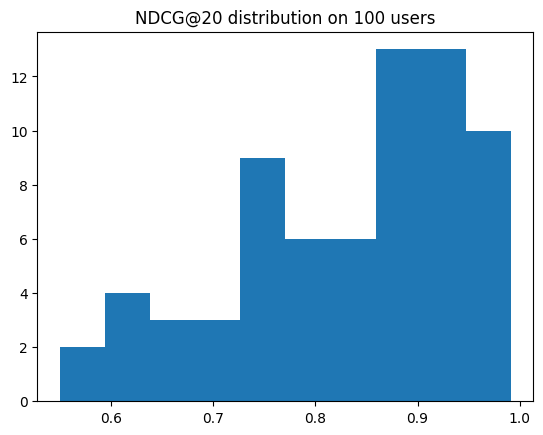

In [184]:
plt.hist(metric_values)
plt.title('NDCG@20 distribution on 100 users')
None

#### positive_count=5

т.е. ранжируем 20 строк, среди которых таргеты 5 единиц и 15 нулей

In [186]:
# считаю метрику NDCG@20 на выборке юзеров
metric_values = []
random_metric_values = []

for user in tqdm(users):
    val, rand_val = evaluate_recs_for_user(user, k=20, positive_count=5)

    # не беру -1 (некорректные случаи - мало строк K < 20)
    if val >= 0:
        metric_values.append(val)
        random_metric_values.append(rand_val)

100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


In [187]:
print('Model score:')
print('Mean NDCG@20', sum(metric_values) / len(metric_values))

print('\nRandom ranking score:')
print('Mean NDCG@20', sum(random_metric_values) / len(random_metric_values))

Model score:
Mean NDCG@20 0.6754123364895965

Random ranking score:
Mean NDCG@20 0.5748089903172127


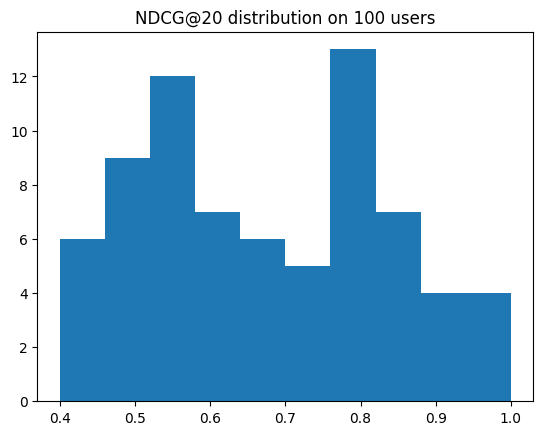

In [188]:
plt.hist(metric_values)
plt.title('NDCG@20 distribution on 100 users')
None

#### positive_count=3

т.е. ранжируем 20 строк, среди которых таргеты 3 единиц и 17 нулей

In [189]:
# считаю метрику NDCG@20 на выборке юзеров
metric_values = []
random_metric_values = []

for user in tqdm(users):
    val, rand_val = evaluate_recs_for_user(user, k=20, positive_count=3)

    # не беру -1 (некорректные случаи - мало строк K < 20)
    if val >= 0:
        metric_values.append(val)
        random_metric_values.append(rand_val)

100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


In [190]:
print('Model score:')
print('Mean NDCG@20', sum(metric_values) / len(metric_values))

print('\nRandom ranking score:')
print('Mean NDCG@20', sum(random_metric_values) / len(random_metric_values))

Model score:
Mean NDCG@20 0.5943760305067151

Random ranking score:
Mean NDCG@20 0.4963000249797694


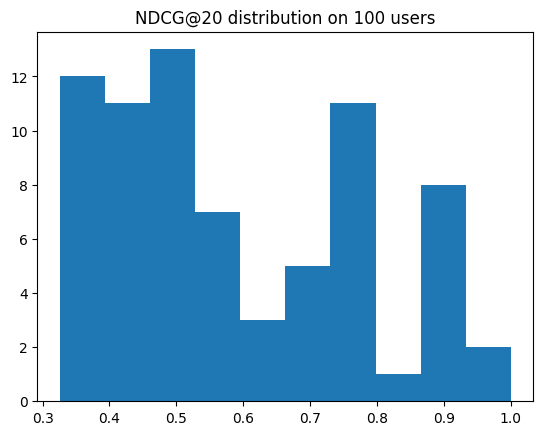

In [191]:
plt.hist(metric_values)
plt.title('NDCG@20 distribution on 100 users')
None

## Results

1. Проанализированы и предобработаны данные

2. Обучена модель бинарной классификации - градиентный бустинг

3. Реализован алгоритм ранжирования на основе псевдовероятностей из бустинга

4. Подсчитаны метрики NDCG@20 в 3 случаях:
    1. NDCG@20=0.8356 при positive_count=10
    2. NDCG@20=0.6754 при positive_count=5
    3. NDCG@20=0.5944 при positive_count=3
    
5. Во всех случаях алгоритм показал себя лучше, чем базовый (рандомное ранжирование)